In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import warnings

from concurrent.futures import ThreadPoolExecutor
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
from tqdm import tqdm
warnings.filterwarnings('ignore')


warnings.filterwarnings('ignore')

In [2]:
folders = [
    "XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_1",    
    "XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_2",
    "XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_3",
    "XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_4",
    "XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_5",
    "XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_1",
    "XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_2",
    "XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_3",
    "XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_4",
    "XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_5",
    "XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_1",
    "XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_2",
    "XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_3",
    "XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_4",
    "XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_5"
]

In [3]:
def antiGradient(X):
    grad = np.zeros(len(X))
    prev = X[0]
    for i in range(len(X)):
        grad[i] = X[i] + prev
        prev = X[i]

    return grad


def norm(data):
    return (data-data.mean())/(data.max()-data.min())

# previous implementation
def find_fault_start_indices(arr):

    reference_amp = np.max(arr[25:225])
    
    medium_severity_indices = np.where(arr >  6* reference_amp)[0]
    high_severity_indices = np.where(arr > 25 * reference_amp)[0]

    if len(medium_severity_indices)==0:
        medium_severity_index = None
    else:
        medium_severity_index = medium_severity_indices[0]

    if len(high_severity_indices)==0:
        high_severity_index = None
    else:
        high_severity_index = high_severity_indices[0]
    return medium_severity_index, high_severity_index

# new implementation
def find_fault_start_indices_with_rms(arr):

    # rms_values = rms_window(arr)
    rms_values = rms_window_fast(arr)
    rms_values_flatten = flatten_rms(rms_values)
    rms_diff = 10000*(rms_values_flatten[1:] - rms_values_flatten[:-1])

    # plt.figure(figsize=(15,5))
    # plt.plot(rms_diff)
    # plt.show()
    medium_severity_indices = np.where(rms_diff >  4)[0]
    high_severity_indices = np.where(rms_diff > 16)[0]

    if len(medium_severity_indices)==0:
        medium_severity_index = None
    else:
        medium_severity_index = medium_severity_indices[0]

    if len(high_severity_indices)==0:
        high_severity_index = None
    else:
        high_severity_index = high_severity_indices[0]
    return medium_severity_index, high_severity_index


def plot_with_severity(X, ms_idx=None, hs_idx=None):
    plt.figure(figsize=(15,4))
    plt.plot(X)
    # plt.plot(norm(X))
    if ms_idx is not None:
        plt.axvline(x=ms_idx, color='red', linestyle='--', label=f'Partition at Medium Severity')
    if hs_idx is not None:
        plt.axvline(x=hs_idx, color='red', linestyle='--', label=f'Partition for High Severity')
    if ms_idx and hs_idx:
        plt.title("Severity Plot")
    plt.show()

def find_severity(X, grad_show=False):
    # calculate anti gradient
    prev = norm(X)
    for i in tqdm(range(10)):
        grad = antiGradient(prev)
        prev = norm(grad)

    #find indices for severity
    # ms_idx, hs_idx = find_fault_start_indices(abs(grad))
    ms_idx, hs_idx = find_fault_start_indices_with_rms(abs(grad))

    plot_with_severity(X, ms_idx, hs_idx)
    
    if grad_show:
        plot_with_severity(grad)

    return ms_idx, hs_idx

def rms_window(signal, window_size=500):
    # Number of RMS points
    rms_values = np.zeros(len(signal) - window_size + 1)
    
    # Loop through the signal and compute RMS for each window
    for i in range(len(rms_values)):
        window = signal[i:i + window_size]
        rms_values[i] = np.sqrt(np.mean(window**2))
    
    return rms_values

def rms_window_fast(signal, window_size=500):
    # Number of RMS points
    rms_values = np.zeros(len(signal) - window_size)
    
    # Loop through the signal and compute RMS for each window
    squared_sum = np.sum(signal[0:window_size]**2)
    for i in range(len(rms_values)):
        rms_values[i] = np.sqrt(squared_sum/window_size)
        squared_sum = squared_sum + signal[i+window_size]**2
        squared_sum = squared_sum - signal[i]**2
    
    return rms_values

def flatten_rms(rms_values):
    maxi = rms_values[0]
    for i in range(len(rms_values)):
        if rms_values[i]> maxi:
            maxi = rms_values[i]
        rms_values[i] =  maxi

    return rms_values

In [4]:
def get_vibrationdata(file_path):
    return pd.read_csv(file_path).values

In [5]:
X = []
f = [5, 6, 7, 8, 9]
for idx in tqdm(f):
    path = folders[idx]
    files = sorted(int(f.split('.')[0]) for f in os.listdir(path))
    all_horizontal_data = np.concatenate([get_vibrationdata(os.path.join(path, f'{f}.csv'))[1:, 0] for f in files])
    X.append(all_horizontal_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.25s/it]


## Classification

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.io

In [7]:
base_dir = os.path.dirname(os.getcwd())
codes_dir = os.path.join(base_dir, "functions")
if codes_dir not in sys.path:
    sys.path.append(codes_dir)

In [8]:
def norm(data):
    return (data - data.mean())/(data.max() - data.min())

In [9]:
def trim_signal_with_class(signal, window_size=4096, target_class=None, sampling_rate = 1):

    signal = signal[::sampling_rate]
    num_windows = len(signal) // window_size
    
    # Trim the signal into windows
    X_data = np.array([signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)])
    
    y_data = np.array([target_class]*num_windows)

    return X_data, y_data

def push_data(X_t, y_t, X_data, y_data):
    for y, z in zip(X_data, y_data):
        X_t.append(y)
        y_t.append(z)

    return X_t, y_t

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from multiprocessing import Pool

2024-12-04 10:24:36.550704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [11]:
# np.random.seed(42)
def train_val_test_split(X, y, val_test_size=0.1):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Use the shuffled indices to shuffle data and labels
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # Split the shuffled data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=2*val_test_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate model on training data
    loss_train, acc_train = model.evaluate(X_train, y_train, verbose=0)
    
    print('The accuracy of the model for training data is:', acc_train * 100)
    print('The Loss of the model for training data is:', loss_train)
    
    # Evaluate model on validation data
    loss_val, acc_val = model.evaluate(X_val, y_val, verbose=0)
    
    print('The accuracy of the model for validation data is:', acc_val * 100)
    print('The Loss of the model for validation data is:', loss_val)

    # Evaluation
    loss_test, acc_test = model.evaluate(X_test, y_test, verbose=0)
    
    print('The accuracy of the model for testing data is:', acc_test * 100)
    print('The Loss of the model for testing data is:', loss_test)

In [12]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(16,4))
    
    # Plotting loss vs epoch
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    
    # Plotting accuracy vs epoch
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

In [22]:
#BALANCED
balance = 1

X_DATA = []
y_DATA = []
classes = [0, 1, 2, 3, 2, 2]
idx = 1
for x in X:
    m_idx, h_idx = find_fault_start_indices(x)
    if m_idx is None:
        print("Fault")
        break
    signal_normal = x[0:m_idx//6]
    signal_faulty = x[m_idx:]
    
    X_data, y_data = trim_signal_with_class(signal_normal, 256, 0, 1)
    # X_DATA, y_DATA = push_data(X_DATA, y_DATA, X_data, y_data)
    X_DATA, y_DATA = push_data(X_DATA, y_DATA, X_data[:len(X_data)//2], y_data[:len(X_data)//2])
    X_data, y_data = trim_signal_with_class(signal_faulty, 256, classes[idx], 1)
    # X_DATA, y_DATA = push_data(X_DATA, y_DATA, X_data, y_data)
    X_DATA, y_DATA = push_data(X_DATA, y_DATA, X_data[:len(X_data)//2], y_data[:len(X_data)//2])
    
    if balance and idx==1:
        for i in range(1, 8):
            X_data, y_data = trim_signal_with_class(signal_faulty[i:], 256, classes[idx], 1)
            X_DATA, y_DATA = push_data(X_DATA, y_DATA, X_data, y_data)
    idx += 1
# if balance:
#     X_DATA = X_DATA[1000:-13200]
#     y_DATA = y_DATA[1000:-13200]
    
X_DATA = np.array(X_DATA)
y_DATA = np.array(y_DATA)

In [23]:
print(X_DATA.shape)
print(y_DATA.shape)

(60198, 256)
(60198,)


In [24]:
unique_values, counts = np.unique(y_DATA, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3]
Counts: [12169 22327 12471 13231]


In [25]:
np.save("Bearing__2_1__2_2__2_3__2_4__2_5__signals_unsampled.npy", X_DATA)

##### ================================================================================

### Wigner Ville Classification

In [ ]:
# del X_DATA

In [27]:
def wigner_ville(signal):
    n = len(signal)
    wvd = np.zeros((n, n), dtype=np.complex128)

    for t1 in range(n):
        for t2 in range(n):
            tau = t2 - t1
            if 0 <= tau < n:
                wvd[t1, t2] = signal[t1] * np.conj(signal[t2]) if t1 != t2 else 0

    return np.fft.fftshift(np.fft.fft2(wvd))

In [28]:
from tqdm import tqdm
import numpy as np

X_image = []
directory = "wvd_images"
for batch in tqdm(range(1, 22)):
    data = np.load(f"{directory}/Bearing__2_1__2_2__2_3__2_4__2_5__unsampled__batch_{batch}.npy")
    for d in data:
        X_image.append(d)
X_image = np.array(X_image)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.38it/s]


In [29]:
X_image.shape

(60198, 256, 256, 1)

In [23]:
# del X_image

#### Training

In [30]:
y_image = np.eye(4)[y_DATA]
# y_image = y_DATA
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_image, y_image, 0.1)

In [31]:
del X_image
del y_image

In [32]:
# -*- coding: utf-8 -*-
'''ResNet model for Keras.

# Reference:

- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings


from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.initializers import HeNormal, GlorotNormal




def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.
    """
    # filters1, filters2, filters3 = filters
    filters1, filters3 = filters

    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), kernel_initializer=HeNormal(), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # x = Conv2D(filters2, kernel_size,
    #            padding='same', name=conv_name_base + '2b')(x)
    # x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    # x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), kernel_initializer=HeNormal(), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.

    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    # filters1, filters2, filters3 = filters
    filters1, filters3 = filters
    
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), kernel_initializer=HeNormal(), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # x = Conv2D(filters2, kernel_size, padding='same',
    #            name=conv_name_base + '2b')(x)
    # x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    # x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), kernel_initializer=HeNormal(), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet_custom(input_shape=None, classes=4):

    img_input = Input(shape=input_shape)
    
    bn_axis = 3

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=HeNormal(), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [32, 32], stage=2, block='a', strides=(1, 1))
    # x = identity_block(x, 3, [64, 256], stage=2, block='b')
    # x = identity_block(x, 3, [64, 256], stage=2, block='c')

    # x = conv_block(x, 3, [128, 512], stage=3, block='a')
    # x = identity_block(x, 3, [128, 512], stage=3, block='b')
    # x = identity_block(x, 3, [128, 512], stage=3, block='c')
    # x = identity_block(x, 3, [128, 512], stage=3, block='d')

    x = conv_block(x, 3, [64, 64], stage=4, block='a', strides=(1,1))
    x = identity_block(x, 3, [64, 64], stage=4, block='b')
    # x = identity_block(x, 3, [256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [32, 32], stage=4, block='f')

    x = conv_block(x, 3, [128, 128], stage=5, block='a', strides=(1,1))
    # x = identity_block(x, 3, [512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    x = Flatten()(x)
    
    x = Dense(classes, activation='softmax', kernel_initializer=HeNormal(), name='fc10')(x)
    
    # Create model.
    model = Model(img_input, x, name='resnet_custom')

    # optimizer = Adam(learning_rate=0.001,beta_1=0.999)
    optimizer = Adam(learning_rate=0.0001,beta_1=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [33]:
model = ResNet_custom(input_shape=X_train.shape[1:], classes=4)

2024-12-04 11:09:25.313933: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-04 11:09:25.575161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-04 11:09:25.790933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2024-12-04 11:09:25.791021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-12-04 11:09:26.069517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-12-04 11:09:26.069582: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

In [34]:
model.summary()

Model: "resnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
______________________________________________________________________________________

In [35]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

2024-12-04 11:09:55.389399: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12624330752 exceeds 10% of free system memory.
2024-12-04 11:10:04.868663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-04 11:10:04.958136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200140000 Hz


Epoch 1/30


2024-12-04 11:10:06.565163: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-12-04 11:10:08.191987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1505/1505 [==============================] - 95s 57ms/step - loss: 0.3175 - accuracy: 0.8856 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 2/30
1505/1505 [==============================] - 83s 55ms/step - loss: 0.0294 - accuracy: 0.9896 - val_loss: 0.0317 - val_accuracy: 0.9882
Epoch 3/30
1505/1505 [==============================] - 83s 55ms/step - loss: 0.0211 - accuracy: 0.9923 - val_loss: 0.0262 - val_accuracy: 0.9907
Epoch 4/30
1505/1505 [==============================] - 83s 55ms/step - loss: 0.0135 - accuracy: 0.9953 - val_loss: 0.0091 - val_accuracy: 0.9970
Epoch 5/30
1505/1505 [==============================] - 82s 55ms/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.0082 - val_accuracy: 0.9977
Epoch 6/30
1505/1505 [==============================] - 82s 55ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0081 - val_accuracy: 0.9975
Epoch 7/30
1505/1505 [==============================] - 83s 55ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0104 - val_accura

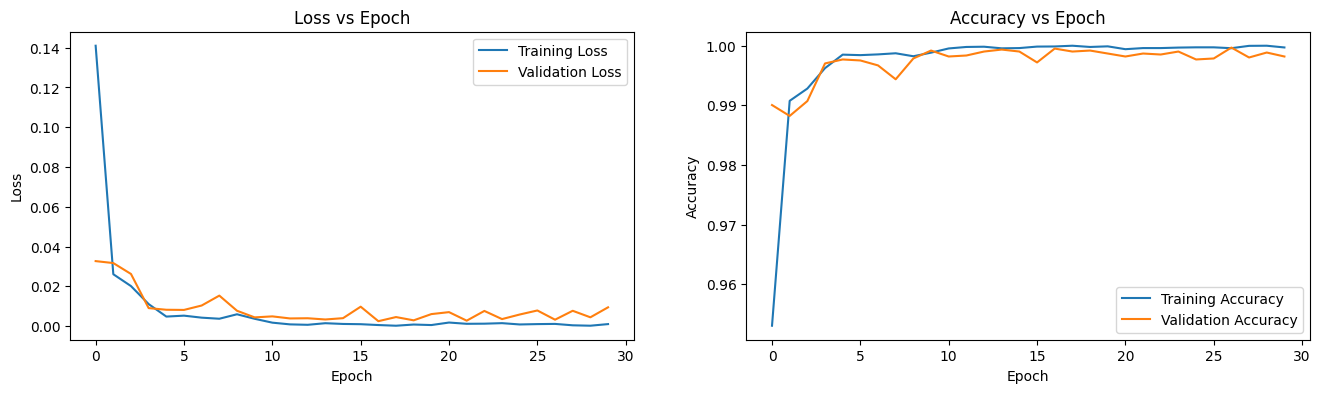

In [36]:
plot_loss_accuracy(history)

In [37]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

2024-12-04 12:14:40.438787: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12624330752 exceeds 10% of free system memory.


The accuracy of the model for training data is: 99.97300505638123
The Loss of the model for training data is: 0.0006621084176003933
The accuracy of the model for validation data is: 99.81727600097656
The Loss of the model for validation data is: 0.009442788548767567
The accuracy of the model for testing data is: 99.83388781547546
The Loss of the model for testing data is: 0.0068574766628444195


In [38]:
model.save("Bearing__2_1__2_2__2_3__2_4__2_5__unsampled__model.h5")

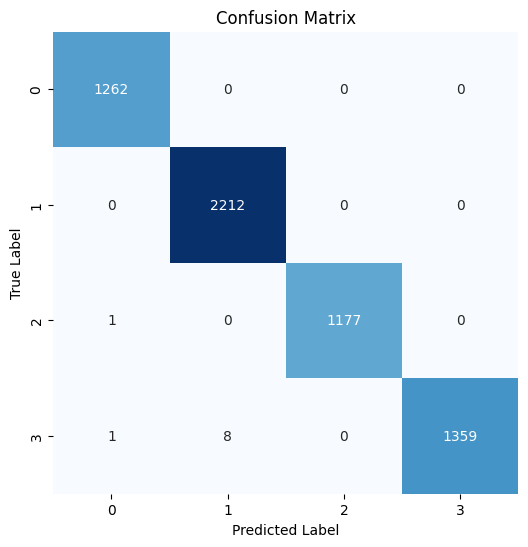

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Test on Other

In [40]:
from tensorflow.keras.models import load_model
model = load_model("Bearing__2_1__2_2__2_3__2_4__2_5__unsampled__model.h5")

In [41]:
model.summary()

Model: "resnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
______________________________________________________________________________________

In [24]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

2024-11-19 17:54:04.997701: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 11803820032 exceeds 10% of free system memory.
2024-11-19 17:54:13.122094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-11-19 17:54:13.142571: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199915000 Hz
2024-11-19 17:54:13.562458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-19 17:54:13.773187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


The accuracy of the model for training data is: 99.98001456260681
The Loss of the model for training data is: 0.0008645298657938838
The accuracy of the model for validation data is: 99.98223781585693
The Loss of the model for validation data is: 0.0003822508151642978
The accuracy of the model for testing data is: 99.98223781585693
The Loss of the model for testing data is: 0.0003646984987426549


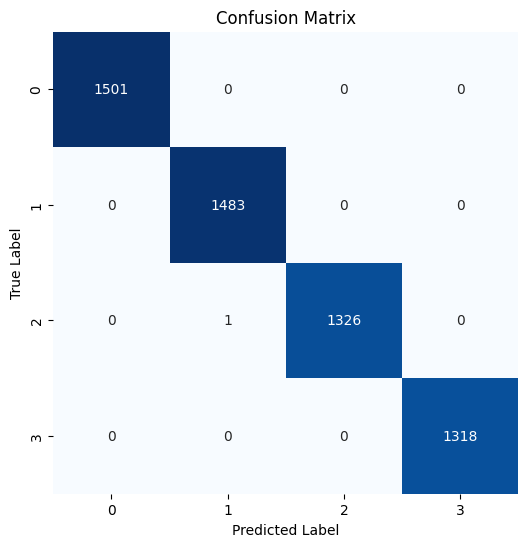

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Test on 2_4, 2_5

In [27]:
X_t = []
f_t = [8, 9]
for idx in tqdm(f_t):
    path = folders[idx]
    files = sorted(int(f.split('.')[0]) for f in os.listdir(path))
    all_horizontal_data = np.concatenate([get_vibrationdata(os.path.join(path, f'{f}.csv'))[1:, 0] for f in files])
    X_t.append(all_horizontal_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.51s/it]


In [28]:

X_DATA_t = []
y_DATA_t = []
classes = [0, 2]
idx = 1
for x in X_t:
    m_idx, h_idx = find_fault_start_indices(x)
    if m_idx is None:
        print("Fault")
        break
    signal_normal = x[0:m_idx]
    signal_faulty = x[m_idx:]
    
    X_data_t, y_data_t = trim_signal_with_class(signal_normal, 256, 0, 4)
    X_DATA_t, y_DATA_t = push_data(X_DATA_t, y_DATA_t, X_data_t, y_data_t)
    X_data_t, y_data_t = trim_signal_with_class(signal_faulty, 256, classes[idx], 4)
    X_DATA_t, y_DATA_t = push_data(X_DATA_t, y_DATA_t, X_data_t, y_data_t)
    print(f"size of signal {len(x)//(4*256)}")
    
X_DATA_t = np.array(X_DATA_t)
y_DATA_t = np.array(y_DATA_t)

size of signal 1343
size of signal 10847


In [29]:
X_DATA_t.shape

(12190, 256)

In [30]:
np.save("Bearing__2_4__2_5__signals.npy", X_DATA_t)

In [31]:
from tqdm import tqdm
import numpy as np

X_image_t = []
directory = "wvd_images"
for batch in tqdm(range(1, 22)):
    data = np.load(f"{directory}/Bearing__2_4__2_5__batch_{batch}.npy")
    for d in data:
        X_image_t.append(d)
X_image_t = np.array(X_image_t)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:43<00:00,  2.05s/it]


In [32]:
y_image_t = np.eye(4)[y_DATA_t]
y_pred_t = np.argmax(model.predict(X_image_t), axis = 1)

In [33]:
model.predict(X_image_t)[:5]

array([[1.0000000e+00, 1.1407499e-25, 7.1329144e-11, 1.4179903e-20],
       [9.9997056e-01, 1.2364618e-24, 2.9414530e-05, 2.7753579e-15],
       [9.9999833e-01, 8.5074085e-20, 1.6647090e-06, 4.6982945e-11],
       [1.0000000e+00, 4.7451148e-26, 3.4938619e-10, 3.3771455e-20],
       [1.0000000e+00, 3.0221254e-31, 1.0836092e-19, 6.3122080e-26]],
      dtype=float32)

In [35]:
unique_values, counts = np.unique(y_pred_t, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 2 3]
Counts: [8432 3656  102]


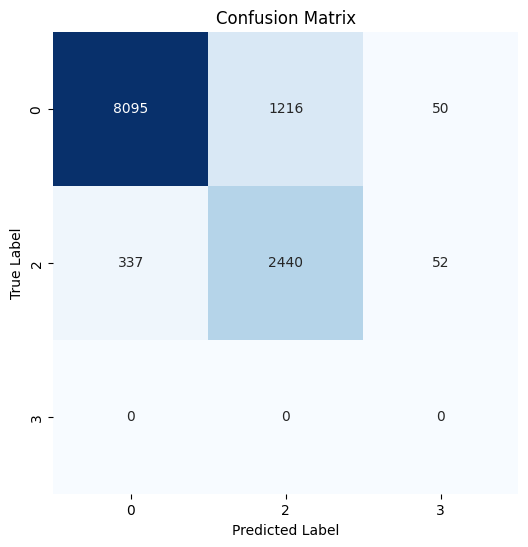

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_true = np.argmax(y_test, axis=1)
y_DATA_t
y_pred_t = np.argmax(model.predict(X_image_t), axis=1)

conf_matrix = confusion_matrix(y_DATA_t, y_pred_t)

plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 2, 3], yticklabels=[0, 2, 3])
#plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
acc = np.sum(y_DATA_t==y_pred_t)/len(y_image_t)*100
print(f"Accuracy: {round(acc, 2)}")

Accuracy: 86.42


#### Test on 1_1, 1_2, 1_3, 1_4

In [42]:
X_t = []
f_t = [0, 1, 2, 3]
for idx in tqdm(f_t):
    path = folders[idx]
    files = sorted(int(f.split('.')[0]) for f in os.listdir(path))
    all_horizontal_data = np.concatenate([get_vibrationdata(os.path.join(path, f'{f}.csv'))[1:, 0] for f in files])
    X_t.append(all_horizontal_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.56s/it]


In [43]:
X_DATA_t = []
y_DATA_t = []
classes = [0, 2, 2, 2, 3]
idx = 1
for x in X_t:
    m_idx, h_idx = find_fault_start_indices(x)
    if m_idx is None:
        print("Fault")
        break
    signal_normal = x[0:m_idx]
    signal_faulty = x[m_idx:]
    
    X_data_t, y_data_t = trim_signal_with_class(signal_normal, 256, 0, 4)
    X_DATA_t, y_DATA_t = push_data(X_DATA_t, y_DATA_t, X_data_t, y_data_t)
    X_data_t, y_data_t = trim_signal_with_class(signal_faulty, 256, classes[idx], 4)
    X_DATA_t, y_DATA_t = push_data(X_DATA_t, y_DATA_t, X_data_t, y_data_t)
    print(f"size of signal {len(x)//(4*256)}")
    idx += 1
    
X_DATA_t = np.array(X_DATA_t)
y_DATA_t = np.array(y_DATA_t)

size of signal 3935
size of signal 5151
size of signal 5055
size of signal 3903


In [44]:
X_DATA_t.shape

(18042, 256)

In [42]:
np.save("Bearing__1_1__1_2__1_3__1_4__signals.npy", X_DATA_t)

In [45]:
from tqdm import tqdm
import numpy as np

X_image_t = []
directory = "wvd_images"
for batch in tqdm(range(1, 22)):
    data = np.load(f"{directory}/Bearing__1_1__1_2__1_3__1_4__batch_{batch}.npy")
    for d in data:
        X_image_t.append(d)
X_image_t = np.array(X_image_t)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:19<00:00,  3.77s/it]


In [46]:
y_image_t = np.eye(4)[y_DATA_t]
y_pred_t = np.argmax(model.predict(X_image_t), axis = 1)

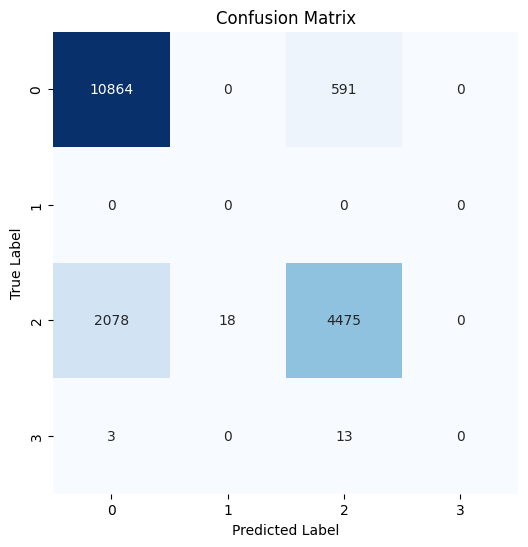

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_true = np.argmax(y_test, axis=1)
# y_DATA_t
y_pred_t = np.argmax(model.predict(X_image_t), axis=1)

conf_matrix = confusion_matrix(y_DATA_t, y_pred_t)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [48]:
acc = np.sum(y_DATA_t==y_pred_t)/len(y_image_t)*100
print(f"Accuracy: {round(acc, 2)}")

Accuracy: 85.02


In [49]:
model.predict(X_image_t)[:10]

array([[1.26884878e-01, 6.20490862e-16, 8.73115122e-01, 4.75745853e-20],
       [1.00000000e+00, 1.48022534e-12, 1.20817609e-11, 2.13368238e-25],
       [9.99967694e-01, 5.66497786e-18, 3.23323256e-05, 5.43147527e-27],
       [1.00000000e+00, 7.17472482e-14, 3.31781857e-13, 1.14842320e-22],
       [9.99870777e-01, 3.54251117e-15, 1.29167500e-04, 3.48480109e-20],
       [9.99998093e-01, 7.38795761e-11, 1.89786351e-06, 1.01009067e-19],
       [1.00000000e+00, 7.05756134e-19, 1.03588791e-08, 4.67008648e-19],
       [8.55057538e-01, 2.09349530e-12, 1.44942477e-01, 9.69683365e-24],
       [9.27546084e-01, 7.13525864e-13, 7.24538937e-02, 2.90532973e-19],
       [9.42256391e-01, 1.47401868e-10, 5.77435941e-02, 2.35091980e-21]],
      dtype=float32)

In [50]:
unique_values, counts = np.unique(y_pred_t, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2]
Counts: [12945    18  5079]


#### Test on 3_1, 3_3, 3_4, 3_5

In [14]:
X_t = []
f_t = [10, 12, 13, 14]
for idx in tqdm(f_t):
    path = folders[idx]
    files = sorted(int(f.split('.')[0]) for f in os.listdir(path))
    all_horizontal_data = np.concatenate([get_vibrationdata(os.path.join(path, f'{f}.csv'))[1:, 0] for f in files])
    X_t.append(all_horizontal_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.77s/it]


In [20]:
X_DATA_t = []
y_DATA_t = []
classes = [0, 2, 1, 1, 2]
idx = 1
for x in X_t:
    m_idx, h_idx = find_fault_start_indices(x)
    if m_idx is None:
        print("Fault")
        break
    signal_normal = x[0:m_idx//25]
    signal_faulty = x[m_idx:]
    
    X_data_t, y_data_t = trim_signal_with_class(signal_normal, 256, 0, 4)
    X_DATA_t, y_DATA_t = push_data(X_DATA_t, y_DATA_t, X_data_t, y_data_t)
    X_data_t, y_data_t = trim_signal_with_class(signal_faulty, 256, classes[idx], 4)
    X_DATA_t, y_DATA_t = push_data(X_DATA_t, y_DATA_t, X_data_t, y_data_t)
    print(f"size of signal {len(x)//(4*256)}")
    idx += 1
    
X_DATA_t = np.array(X_DATA_t)
y_DATA_t = np.array(y_DATA_t)

size of signal 81213
size of signal 11871
size of signal 48478
size of signal 3647


In [21]:
X_DATA_t.shape

(14050, 256)

In [22]:
from tqdm import tqdm
import numpy as np

X_image_t = []
directory = "wvd_images"
for batch in tqdm(range(1, 22)):
    data = np.load(f"{directory}/Bearing__3_1__3_3__3_4__3_5__batch_{batch}.npy")
    for d in data:
        X_image_t.append(d)
X_image_t = np.array(X_image_t)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.02it/s]


In [23]:
X_image_t.shape

(14050, 256, 256, 1)

2024-11-20 16:35:02.265948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-11-20 16:35:02.286697: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199915000 Hz
2024-11-20 16:35:02.530823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-20 16:35:02.681770: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


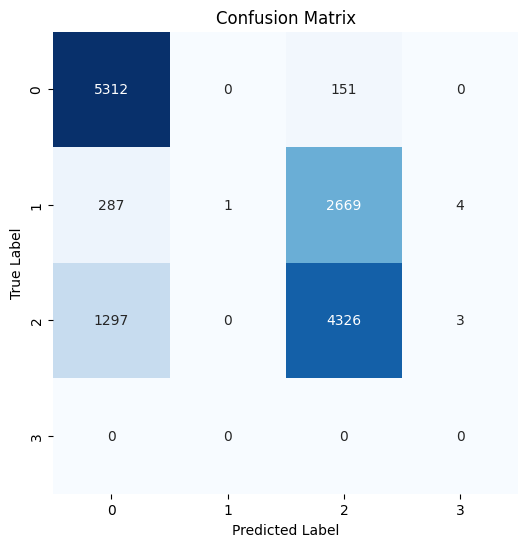

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_true = np.argmax(y_test, axis=1)
# y_DATA_t
y_pred_t = np.argmax(model.predict(X_image_t), axis=1)

conf_matrix = confusion_matrix(y_DATA_t, y_pred_t)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
acc = np.sum(y_DATA_t==y_pred_t)/len(y_DATA_t)*100
print(f"Accuracy: {round(acc, 2)}")

Accuracy: 68.6


In [26]:
model.predict(X_image_t)[:10]

array([[1.00000000e+00, 3.43231114e-31, 1.00834943e-25, 3.39406591e-34],
       [1.00000000e+00, 1.45785676e-32, 2.53295693e-20, 3.20847064e-30],
       [1.00000000e+00, 8.30607209e-27, 8.06536370e-13, 2.30611638e-20],
       [1.00000000e+00, 0.00000000e+00, 4.37177602e-24, 1.42607690e-37],
       [1.00000000e+00, 2.88041121e-24, 2.67123320e-11, 1.16622137e-18],
       [1.00000000e+00, 0.00000000e+00, 6.21895300e-24, 2.43297943e-33],
       [1.00000000e+00, 7.29537328e-29, 8.50464966e-16, 4.82172535e-22],
       [1.00000000e+00, 0.00000000e+00, 1.12548276e-33, 5.82554793e-37],
       [1.00000000e+00, 1.13242967e-25, 3.25644563e-17, 8.99041777e-30],
       [1.00000000e+00, 5.42819441e-26, 1.89996283e-11, 7.53424390e-23]],
      dtype=float32)

In [27]:
unique_values, counts = np.unique(y_pred_t, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3]
Counts: [6896    1 7146    7]


In [28]:
unique_values, counts = np.unique(y_DATA_t, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2]
Counts: [5463 2961 5626]
